In [ ]:
# This is an example GPT style decoder only transformer model and example dataset
# This an example of the use of the icanswim/cosmosis repo for data science and 
# machine learning projects

In [2]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from cosmosis.dataset import AsTensor
from cosmosis.learning import Learn, Selector, Metrics
from cosmosis.model import GPT

from dataset import TinyShakes

In [2]:
# explore the ds

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'd_seq': 10,
            'n': 5}

ts = TinyShakes(**ds_param)

print(ts[0])
print(ts[0]['tokens'].shape, ts[0]['tokens'].dtype)
print(ts[0]['y'].shape, ts[0]['y'].dtype)
print('decoded tokens: ', ts.encoding.decode(ts[0]['tokens'].tolist()))
print('decoded y: ', ts.encoding.decode(ts[0]['y'].tolist()))


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyshakes_stripped_encoded.bin
len(self.ds_idx):  5
data.nbytes:  602664
CDataset created...
{'tokens': tensor([ 5962, 22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285]), 'y': tensor([22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285,   502]), 'position': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}
torch.Size([10]) torch.int64
torch.Size([10]) torch.int64
decoded tokens:  First Citizen: Before we proceed any further, hear
decoded y:   Citizen: Before we proceed any further, hear me


In [3]:
# example using prompt for inference

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'prompt': 'First Citizen: Before we proceed any further, hear '}

prompt = TinyShakes(**ds_param)
print(prompt[0])
print(prompt[0]['tokens'].shape)
# y wont be used in inference but is generated automatically 
# as part of the reuse of the getitem machinery
print(prompt[0]['y'].shape) 
print('decoded tokens: ', prompt.encoding.decode(prompt[0]['tokens'].tolist()))
print('decoded y: ', prompt.encoding.decode(prompt[0]['y'].tolist()))

len(self.ds_idx):  1
data.nbytes:  22
CDataset created...
{'tokens': tensor([ 5962, 22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285,
          220]), 'y': tensor([22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285,   220]), 'position': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}
torch.Size([11])
torch.Size([10])
decoded tokens:  First Citizen: Before we proceed any further, hear 
decoded y:   Citizen: Before we proceed any further, hear 


In [4]:
# pass a single example from dataset to model to loss function
# (batch, d_seq, d_model)

d_seq = 3 # dimension sequence
d_vocab = 50304 # dimension vocabulary
d_vec = 4 # dimension embedding vector
d_model = 4 # dimension model input

assert d_model == d_vec

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'd_seq': d_seq,
            'n': 5}

ts = TinyShakes(**ds_param)

print(ts[0])
print(ts[0]['tokens'].shape, ts[0]['tokens'].dtype)
print(ts[0]['y'].shape, ts[0]['y'].dtype)
print('decoded tokens: ', ts.encoding.decode(ts[0]['tokens'].tolist()))
print('decoded y: ', ts.encoding.decode(ts[0]['y'].tolist()))

model_param = {'device': 'cpu',
               'd_model': d_model, # matches embedding dimension
               'd_vocab': d_vocab, 
               'n_head': 2, 
               'num_layers': 2,
               'd_seq': d_seq,
               'd_vec': d_vec,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               'y': (d_vocab, d_vec, None, True),
                               'position': (d_seq, d_vec, None, True)}} 

gpt = GPT(model_param)

data = ts[0]
out = gpt(data)
print('output: ', out, out.shape, out.dtype)

prompt_tokens = data['tokens']
print('prompt_tokens: ', prompt_tokens, prompt_tokens.shape, prompt_tokens.dtype)

target_tokens = data['y']
print('target_tokens: ', target_tokens, target_tokens.shape, target_tokens.dtype)

generated_embeddings = out.squeeze()
print('generated_embeddings: ', generated_embeddings, generated_embeddings.shape, generated_embeddings.dtype)
print('decoded generated tokens: ', prompt.encoding.decode(generated_embeddings.argmax(dim=-1).tolist()))

cel_func = CrossEntropyLoss()
loss = cel_func(out, target_tokens)
print('loss: ', loss)


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyshakes_stripped_encoded.bin
len(self.ds_idx):  5
data.nbytes:  602664
CDataset created...
{'tokens': tensor([ 5962, 22307,    25]), 'y': tensor([22307,    25,  7413]), 'position': tensor([0, 1, 2])}
torch.Size([3]) torch.int64
torch.Size([3]) torch.int64
decoded tokens:  First Citizen:
decoded y:   Citizen: Before
applying _init_weights...
GPT model loaded...
number of model parameters:  201220
output:  tensor([[ 0.0069,  0.0168,  0.0580,  ..., -0.0273,  0.0639, -0.0131],
        [-0.0019,  0.0078,  0.0237,  ..., -0.0403,  0.0652,  0.0063],
        [-0.0422,  0.0211,  0.0521,  ..., -0.0379,  0.0138, -0.0096]],
       grad_fn=<MmBackward0>) torch.Size([3, 50304]) torch.float32
prompt_tokens:  tensor([ 5962, 22307,    25]) torch.Size([3]) torch.int64
target_tokens:  tensor([22307,    25,  7413]) torch.Size([3]) torch.int64
generated_embeddings:  tensor([[ 0.0069,  0.0168,  0.0580,  ..., -0.0273,  0.0

tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyshakes_stripped_encoded.bin
len(self.ds_idx):  1000
data.nbytes:  602664
CDataset created...
applying _init_weights...
GPT model loaded...
number of model parameters:  38634240
model loaded from state_dict...
loading embedding weights...
running model on gpu...

.....................

total elapsed time: 0:00:07.825424
epoch: 0
y_pred:   midnight behalf island c PR black an ocean deities Say father set Just hostile fought store rise brave blood brain Naples al being kne part deny scope avoidneck away living ch grand willingly Whilstward power wretched lab four candleere remedyantta opposite right beloved Gentle forgiveness But lady Stand smooth On two richesatterID surplus quarrel VOL Whereoth tomb George tender keep alone Juliet bastard owesurned Since doveal burning Berkeley voices Proceed spit resolve foot cheerily noise believe sets abroada PET l finger sister  tough measureans Until ill
y:   l

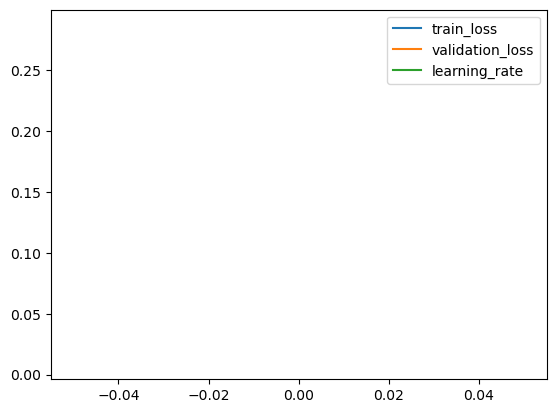

model: tinyshakes768 saved...


In [3]:
# put all together in a learner
# (batch, d_seq, d_model)

d_seq = 100 # dimension sequence
d_vocab = 50304 # dimension vocabulary
d_vec = 768 # dimension embedding vector
d_model = 768 # dimension model input
assert d_model == d_vec

ds_param = {'train_param': {'transforms': {'tokens': [AsTensor()],
                            'y': [AsTensor()],
                            'position': [AsTensor()]},
            'd_seq': d_seq,
            'n': 1000,
                           }}

model_param = {'d_model': d_model,
               'd_vocab': d_vocab, 
               'n_head': 12, 
               'num_layers': 12,
               'd_seq': d_seq,
               'd_vec': d_vec,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               'y': (d_vocab, d_vec, None, True),
                               'position': (d_seq, d_vec, None, True)}} 
                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 1,
                 'log_plot': False,
                 'min_lr': .0025} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=32, epochs=1, gpu=True, save_model='tinyshakes768', 
              load_model='tinyshakes768.pth', load_embed=True, target='y')

In [5]:
# inference
d_gen = 50 # dimension generate number of tokens
d_vocab = 50304 # dimension vocabulary
d_vec = 768 # dimension embedding vector
d_model = 768 # dimension model input
d_pos = 50 # dimension positional encoding d_pos >= max(len(prompt_tokens), d_gen)

assert d_model == d_vec


ds_param = {'train_param': {'transforms': {'tokens': [AsTensor()],
                                           'y': [AsTensor()],
                                           'position': [AsTensor()]},
                            'prompt': 'To be, or not to be, that is the question:'}
           }

model_param = {
               'd_model': d_model,
               'd_vocab': d_vocab, 
               'n_head': 12, 
               'num_layers': 12,
               'd_gen': d_gen,
               'd_vec': d_vec,
               'temperature': 100,
               'top_k': 1000,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               #'y': (d_vocab, d_vec, None, True),
                               'position': (d_pos, d_vec, None, True)},
              } 
                                       
metrics_param = {'metric_name': 'transformer'}                        
             
opt_param = {}

crit_param = {}

sample_param = {}

sched_param = {}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=None, 
              Scheduler=None, 
              Criterion=None, # no criterion implies inference
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=1, epochs=3, gpu=True, 
              load_model='tinyshakes768.pth', load_embed=True, target=None)


len(self.ds_idx):  1
data.nbytes:  26
CDataset created...
applying _init_weights...
GPT model loaded...
number of model parameters:  38634240
model loaded from state_dict...
loading embedding weights...
running model on gpu...

.....................

total learning time: 0:00:01.218606
predictions:  [[' tal I I but;I I,,US:afES willing supplement inhab Xen EVs booked blocks Str paralysis comet mentioning Loramingoola Corm vary hunger angles female Rumble propagationImage IG minimizingLO controlling holiday Royals box cohortserville accusations Alice rode DIRECT HHS camoufl']]
inference instance 2025-03-07 10:56:55.918793 complete and saved to csv...

.....................

total learning time: 0:00:01.307833
predictions:  [['381 I I  thinkIO That,,: afES ButUSRY exceptionsFORzhen realise Str paralysis comet neurot believable stag Professional Woods Sever type angles iss pillreditationImage IG minimizing EricaunciationKa Royals securely indicateerville offered439 rode displayinguesday�'